## The article №2:
* High confidence (mean) and low variability - easy;
* Medium-high confidence and high variability - ambiguous;
* Low confidence and low variability - hard-to-learn.

Article: https://arxiv.org/pdf/2009.10795.pdf

Code: https://github.com/allenai/cartography


## The article №3:
The method avoids:
* Redundant - easy supposedly (the model has already learnt such samples)
* Noisy - ambiguous or incorrect
* Less relevant points - outliers (from low input density)

Article: https://arxiv.org/pdf/2206.07137.pdf

Code: https://github.com/OATML/RHO-Loss

## Goal

The goal: to check if the model proposed in the 3-rd article is able to filter samples the same way as the MSD (mean and standard deviation) model from the 2-nd article does. Or check if the filtration by MSD model can replace RHO-LOSS method from the 3-rd model or maybe it makes final predictions only better/worse.

## The plan

Firstly, proceed MSD with CIFAR10 dataset and check, which samples may be equated to the 3-rd article samples classification, find a way to save the selected samples properly and try out several datasets to find out whether there will be a room for improvement.

## Installation

Make sure that the version of `omegaconf` package is strictly 2.1.

In [1]:
#!pip install rich
#!pip install wandb>=0.12.10
#!pip install omegaconf==2.1
#"progress_bar_refresh_rate": 20

In [2]:
from MSDutils import plot_images, IndexedDataset
from src.datamodules.datasets.sequence_datasets import indices_CIFAR10

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import random
import pandas as pd

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets

SEED=42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# Downloading and assingning already pre-trained msd_hist model:
msd_hist = torch.load("C:/Users/Nezhi/Skoltech/Term 3/Machine Learning/Project/Third/RHOLossmain/msd_hist.pt")

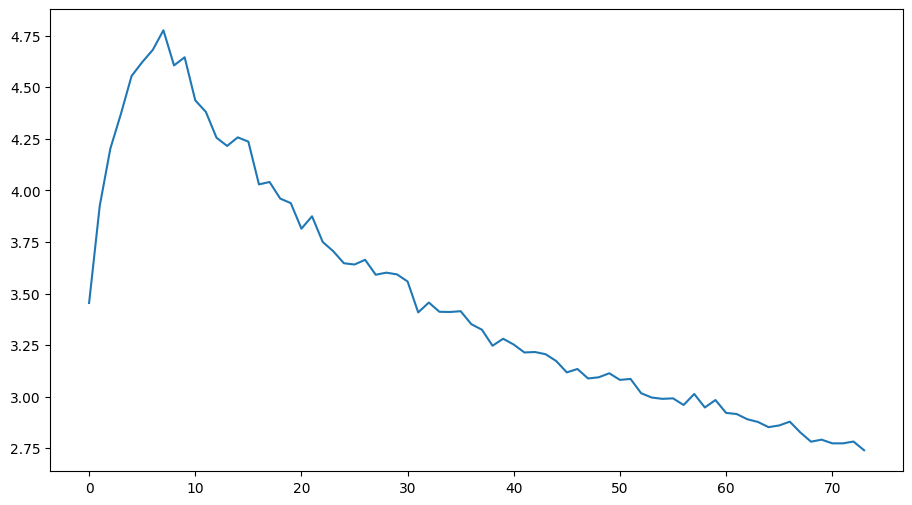

In [5]:
# Checking reproducibility:

NUM_EPOCHS = 75
plt.figure(figsize=(11, 6))
msd_hist = np.array(msd_hist[1:NUM_EPOCHS])
plt.plot(msd_hist.mean(axis=1))
plt.show()

In [6]:
msd_data = pd.read_csv(r'C:\Users\Nezhi\Skoltech\Term 3\Machine Learning\Project\Second\Unsupervisely-Hard-main-new\msd_statistics.csv')
msd_data

,Unnamed: 0,msd_mean,msd_std,disr_score,cluster
0,0,3.279041,1.809704,4.590792,1
1,1,2.037585,0.434451,0.207256,1
2,2,4.009675,1.606036,2.567637,1
3,3,5.026190,1.767881,3.576884,1
4,4,4.029313,1.400813,2.431490,1
...,...,...,...,...,...
49995,49995,5.089722,2.735045,7.741352,1
49996,49996,5.951881,1.795961,5.640676,1
49997,49997,3.037450,1.897557,5.901002,1
49998,49998,3.770800,1.231067,1.102314,1


In [7]:
msd_data.groupby("cluster").count()

,Unnamed: 0,msd_mean,msd_std,disr_score
cluster,,,,
0,18542,18542,18542,18542
1,31458,31458,31458,31458


## Choosing the appropriate samples

As training on the whole and on the ${1/2}$ of the dataset has been conducted by the authors of the original article. There will be a series of experiments with different configurations of `CIFAR10` dataset from the 2-nd and 3-rd articles.

The code in the following cell chooses, **which samples will be `DELETED`** from the training dataset (so the size parameter is **`NOT`** multiplied by 0.33, but **`IS`** multiplied by 0.67). The signatures denote the experiments from the 2-nd article (page 6, table 3): selecting **random 33%** of the initial dataset, **top 33% of `hard-to-learn`** samples and **top 33% of `ambiguous`** samples respectively. The datasets are made, assuming, that `hard-to-learn` samples have low both `mean` and `std`, while `ambiguous` samples have high `std`.

In [8]:
# 33% full random:
random_delete_indices = np.random.choice(50_000, size=int(0.67 * 50_000), replace=False)

# 33% top hard:
hard_df = msd_data.sort_values(['msd_mean', 'msd_std'], ascending=[False, False])
selected_hard_df = hard_df.iloc[:int(len(hard_df)*0.67), :]
hard_delete_indices = np.array(selected_hard_df.index)

# 33% top ambiguous:
ambiguous_df = msd_data.sort_values(['msd_std'], ascending=[True])
selected_ambiguous_df = ambiguous_df.iloc[:int(len(ambiguous_df)*0.67), :]
ambiguous_delete_indices = np.array(selected_ambiguous_df.index)

In [9]:
print(f"Length of the full random dataset: {len(random_delete_indices)};\nLength of the hard-to-learn dataset: {len(hard_delete_indices)};\nLength of the ambiguous dataset: {len(ambiguous_delete_indices)}.")

Length of the full random dataset: 33500;
Length of the hard-to-learn dataset: 33500;
Length of the ambiguous dataset: 33500.


# Training the models

In [10]:
from typing import List, Optional
import os

import numpy as np

import hydra
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning import (
    Callback,
    LightningDataModule,
    LightningModule,
    Trainer,
    seed_everything,
)
from pytorch_lightning.loggers import Logger
import torch
import torch.nn as nn

from src.utils import utils
from src.models.OneModel import OneModel

log = utils.get_logger(__name__)

import pdb

cwd: C:\Users\Nezhi\Skoltech\Term 3\Machine Learning\Project\Third\RHOLossmain\src\datamodules


# Full random 33%

For now there will be demonstrated only experiment with `random_delete_indices` dataset. The rest of the experiments will be done later.

## Irreducible loss model training

We have split all datasets into a "trainset", a "valset", and a "testset".
* The "valset" is what we call the "holdout set" in the paper; it is used for training of the irreducible loss model.
* The "trainset" is what we call the training set in the paper. It is used for training the target model, and as a validation set for the irreducible loss model, to find the epoch with the lowest loss in irreducible loss model training.
* The "testset" is used to evaluate target model performance.

(For earlier experiments, we used the "valset" as the validation set for the target model. However, this was rarely used, as we did not tune any hyperparameters of the target model.)

To go through the following cells, there are several things that must be taken into account:

* Write the path to the required datasets in the next cell.
* A user must have an account on `Wandb.ai` site. To the `my_entity` variable must be assigned the name of the user's team and to the `my_project` variable - the name of the project within that team.

In [11]:
# where to download the datasets
data_dir = "C:/Users/Nezhi/Skoltech/Term 3/Machine Learning/Project/Third/RHOLossmain"

# where to upload the weights and biases logs
my_project = "article_3"
my_entity = "collaboration_team"

The most important parameters in the following cell are `"_target_"` (`src.models.ImportanceSamplingModel.ImportanceSamplingModel` initially) by `"model"` key, `"_target_"` (`src.datamodules.datamodules.SpecifiedCIFAR10DataModule` initially) and `"delete_indices"` (`random_delete_indices.tolist()` initially) by "datamodule" key.
* The first one points which model and which architecture (i.e. `ResNet18`), exactly will be used for that particular training.
* The second one points the exact class of data preprocessing in `datamodules.py` file. **Note:** `SpecifiedCIFAR10DataModule` is a custom class - a slightly modified `CIFAR10DataModule` class, created specifically for training models on lesser datasets (like 33%).
* The third one points, samples with which indices will be removed from the dataset. For now `random_delete_indices` is there, but further `hard_delete_indices` and `ambiguous_delete_indices` will be placed there. **Note:** that parameter only exists in the class `SpecifiedCIFAR10DataModule`, so if it is needed to check the models' performance on another dataset, remove that parameter fully.


There are far more parameters that can be changed but for their exact use and impact it is recommended to read the 3-rd article.

In [12]:
config = {
    "trainer": {
        "_target_": "pytorch_lightning.Trainer",
        "devices": 1,
        "min_epochs": 1,
        "max_epochs": 50,
        "enable_model_summary": None,
        "callbacks": "TQDMProgressBar",
    },
    "model": {
        "_target_": "src.models.ImportanceSamplingModel.ImportanceSamplingModel",
        "model": {
            "_target_": "src.models.modules.resnet_cifar.ResNet18"
        },
    },
    "optimizer": {
        "_target_": "torch.optim.AdamW",
        "lr": 0.001
    },
    "datamodule": {
        "_target_": "src.datamodules.datamodules.SpecifiedCIFAR10DataModule",
        "data_dir": data_dir,
        "batch_size": 320,
        "num_workers": 4,
        "pin_memory": True,
        "shuffle": False,
        "trainset_data_aug": False,
        # This is the irreducible loss model training, so we train on the
        # holdout set (we call this set the "valset" in the global terminology for the dataset
        # splits). Thus, we need augmentation on the valset
        "valset_data_aug": False,
        "delete_indices": random_delete_indices.tolist(),
        
    },
    "callbacks": {
        # We want to save that irreducible loss model with the lowest validation
        # loss (we validate on the "trainset", in global terminology for the
        # dataset splits).
        "model_checkpoint": {
            "_target_": "pytorch_lightning.callbacks.ModelCheckpoint",
            "monitor": "val_loss_epoch",
            "mode": "min",
            "save_top_k": 1,
            "save_last": True,
            "verbose": False,
            "dirpath": os.path.join("tutorial_outputs", "irreducible_loss_model"),
            "filename": "epoch_{epoch:03d}",
            "auto_insert_metric_name": False,
        },
    },
    "logger": {
        # Log with wandb, you could choose a different logger
        "wandb": {
            "_target_": "pytorch_lightning.loggers.wandb.WandbLogger",
            "project": my_project,
            "save_dir": ".",
            "entity": my_entity,
            "job_type": "train",
        }
    },
    "seed": 12,
    "debug": False,
    "ignore_warnings": True,
    "test_after_training": True,
    "base_outdir": "logs",
}

In [ ]:
# convert config to OmegaConf structured dict (default for Hydra), and pretty-print
config = OmegaConf.create(config)
utils.print_config(
    config,
    fields=(
        "trainer",
        "model",
        "datamodule",
        "callbacks",
        "logger",
        "seed",
        "optimizer",
        "scheduler",
    ),
    resolve=True,
)

In [14]:
# Set seed for random number generators in pytorch, numpy and python.random
if "seed" in config:
    seed_everything(config.seed, workers=True)

# Init lightning datamodule
print(f"Instantiating datamodule <{config.datamodule._target_}>")
datamodule: LightningDataModule = hydra.utils.instantiate(config.datamodule)
datamodule.setup()

# Init lightning model
print(f"Instantiating model <{config.model._target_}>")
pl_model: LightningModule = hydra.utils.instantiate(
    config=config.model,
    optimizer_config=utils.mask_config(
        config.get("optimizer", None)
    ),  # When initialising the optimiser, you need to pass it the model parameters. As we haven't initialised the model yet, we cannot initialise the optimizer here.
        # Thus, we need to pass-through the optimizer-config, to initialise it later. However, hydra.utils.instantiate will instatiate everything that looks like a config 
        # (if _recursive_==True, which is required here bc OneModel expects a model argument). Thus, we "mask" the optimizer config from hydra, by modifying the dict so that hydra no longer recognises it as a config.
    scheduler_config=utils.mask_config(
        config.get("scheduler", None)
    ),  # see line above
    datamodule=datamodule,
    _convert_="partial",
)

# Init lightning callbacks. Here, we only use one callback: saving the model
# with the lowest validation set loss. 
callbacks: List[Callback] = []
if "callbacks" in config:
    for _, cb_conf in config.callbacks.items():
        if "_target_" in cb_conf:
            print(f"Instantiating callback <{cb_conf._target_}>")
            callbacks.append(hydra.utils.instantiate(cb_conf))

# Init lightning loggers. Here, we use wandb.
logger: List[Logger] = []
if "logger" in config:
    for _, lg_conf in config.logger.items():
        if "_target_" in lg_conf:
            print(f"Instantiating logger <{lg_conf._target_}>")
            logger.append(hydra.utils.instantiate(lg_conf))

# Init lightning trainer
print(f"Instantiating trainer <{config.trainer._target_}>")
trainer: Trainer = hydra.utils.instantiate(
    config.trainer, callbacks=callbacks, logger=logger, _convert_="partial"
)

# Send config to all lightning loggers
print("Logging hyperparameters!")
trainer.logger.log_hyperparams(config)

# Train the model.
print("Starting training!")
trainer.fit(
    pl_model,
    train_dataloaders=datamodule.val_dataloader(), # see Markdown comment above
    val_dataloaders=datamodule.train_dataloader(), # see Markdown comment above
)

# Evaluate model on test set, using the best model achieved during training
if config.get("test_after_training") and not config.trainer.get("fast_dev_run"):
    print("Starting testing!")
    trainer.test(dataloaders=datamodule.test_dataloader())

def evaluate_and_save_model_from_checkpoint_path(checkpoint_path, name):
    """Compute irreducible loss for the whole trainset with the best model"""

    # load best model
    model = OneModel.load_from_checkpoint(checkpoint_path)
    
    # compute irreducible losses
    model.eval()
    irreducible_loss_and_checks = utils.compute_losses_with_sanity_checks(
        dataloader=datamodule.train_dataloader(), model=model
    )

    # save irred losses in same directory as model checkpoint
    path = os.path.join(
        os.path.dirname(trainer.checkpoint_callback.best_model_path),
        name,
    )
    torch.save(irreducible_loss_and_checks, path)

    return path

saved_path = evaluate_and_save_model_from_checkpoint_path(
    trainer.checkpoint_callback.best_model_path, "irred_losses_and_checks.pt"
)

print(f"Using monitor: {trainer.checkpoint_callback.monitor}")

# Print path to best checkpoint
print(f"Best checkpoint path:\n{trainer.checkpoint_callback.best_model_path}")
print(f"Best checkpoint irred_losses_path:\n{saved_path}")


# Make sure everything closed properly
log.info("Finalizing!")
utils.finish(
    config=config,
    model=pl_model,
    datamodule=datamodule,
    trainer=trainer,
    callbacks=callbacks,
    logger=logger,
)

Seed set to 12


Instantiating datamodule <src.datamodules.datamodules.SpecifiedCIFAR10DataModule>
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Instantiating model <src.models.ImportanceSamplingModel.ImportanceSamplingModel>
Instantiating callback <pytorch_lightning.callbacks.ModelCheckpoint>
Instantiating logger <pytorch_lightning.loggers.wandb.WandbLogger>
Instantiating trainer <pytorch_lightning.Trainer>


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Logging hyperparameters!


wandb: Currently logged in as: nezhit333 (collaboration_team). Use `wandb login --relogin` to force relogin


wandb: WARNING Serializing object of type str that is 227408 bytes


Starting training!


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | ResNet           | 11.2 M
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Epoch 0: 100%|█████████████████████████████████████████████████████████████| 26/26 [00:05<00:00,  4.37it/s, v_num=zy6j]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████| 26/26 [00:20<00:00,  1.26it/s, v_num=zy6j, val_loss_epoch=2.800, val_acc_epoch=0.096]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████| 26/26 [00:20<00:00,  1.26it/s, v_num=zy6j, val_loss_epoch=2.680, val_acc_epoch=0.101]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████| 26/26 [00:20<00:00,  1.29it/s, v_num=zy6j, val_loss_epoch=2.540, val_acc_epoch=0.0975]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████| 26/26 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█████████████████| 26/26 [00:38<00:00,  0.68it/s, v_num=zy6j, val_loss_epoch=2.350, val_acc_epoch=0.107]


Restoring states from the checkpoint path at C:\Users\Nezhi\Skoltech\Term 3\Machine Learning\Project\Third\RHOLossmain\tutorial_outputs\irreducible_loss_model\epoch_048.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing!


Loaded model weights from the checkpoint at C:\Users\Nezhi\Skoltech\Term 3\Machine Learning\Project\Third\RHOLossmain\tutorial_outputs\irreducible_loss_model\epoch_048.ckpt


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.61it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.11580000072717667    │
│         test_loss         │     2.311924695968628     │
└───────────────────────────┴───────────────────────────┘

Computing irreducible loss full training dataset.
Using monitor: val_loss_epoch
Best checkpoint path:
C:\Users\Nezhi\Skoltech\Term 3\Machine Learning\Project\Third\RHOLossmain\tutorial_outputs\irreducible_loss_model\epoch_048.ckpt
Best checkpoint irred_losses_path:
C:\Users\Nezhi\Skoltech\Term 3\Machine Learning\Project\Third\RHOLossmain\tutorial_outputs\irreducible_loss_model\irred_losses_and_checks.pt


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss_used_for_backward_epoch,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_used_for_backward_step,▄▆▅▇▅▅▃▄▇▅▆█▅▅█▃▄▅▄▃▃▃▅▇▁▅
max_p_i_epoch,▅▄▄▃▄█▄▂▄▅▄▃▁▂▄▂▁▁▄▃▅▂▅█▃▂▃▃▆▄▅▅▅▃▆▃▃▂▂▃
max_p_i_step,▂▂▂▃▃▅▂▂▃▂▂▂▇▁▃▂▂▂▁▂▃▂▁▆▂█
num_unique_points_epoch,▅▄▆▆▇▆▂▅▆▆▇▆▅▆▅▅▇▇▄▂▇▄▃█▇▃▄▆▆▃▂▄▅▁▃▆▃▂▇▅
num_unique_points_step,▅██▇▇██▆▅▆▇▆▂▇█▆█▆▇▇▇▅▅▇▆▁
test_acc,▁
test_loss,▁
train_acc_epoch,▁▃▃▃▃▃▄▂▅▄▄▄▃▅▄▅▃▄▄▄▆▅▅▅▅▅▇▆▆▄▇▇▇▇▅█▇███
train_acc_step,▂▃▄▁▃▁▃▂▄▅▆▂▃▂▃█▄▄▃▆▆▃▃▄▅▅


After that on the user's account on `wandb.ai` plots with statistics have appeared. After training the following model it will be possible to evaluate the dynamics in training and results (at least, intermediate results). Remember: `Irriducible loss` model is just an auxiliary model, which helps the main model (the follwing one) to train on the most appropriate samples on the current epoch.

## Target model training

## Creating config

If it is not needed to retrain the `Irriducible loss` model, then it is possible to assign the path, where the file `irred_losses_and_checks.pt` is located to the `saved_path` variable in the following cell.

In [15]:
#saved_path = "C:/Users/.../irred_losses_and_checks.pt"

In [15]:
# where to download the datasets
data_dir = "C:/Users/Nezhi/Skoltech/Term 3/Machine Learning/Project/Third/RHOLossmain"

# where to upload the weights and biases logs
my_project = "article_3"
my_entity = "collaboration_team"

# You could choose any selection method here
# ("src.curricula.selection_methods.xyz"). We have implemented:
# reducible_loss_selection, uniform_selection, ce_loss_selection,
# irreducible_loss_selection, gradnorm_ub_selection, and thers
selection_method = "reducible_loss_selection"

# Path to irreducible losses. Transferred from irreducible loss model training.
# You can replace this with the path if you want to run target model training
# without rerunning irreducible loss model training.
path_to_irreducible_losses = saved_path

In [16]:
config = {
    "model": {
        "_target_": "src.models.MultiModels.MultiModels",
        "large_model": {
            "_target_": "src.models.modules.resnet_cifar.ResNet18"
        },
        "percent_train": 0.1,
    },
    "optimizer": {
        "_target_": "torch.optim.AdamW",
        "lr": 0.001
    },
    "trainer": {
        "_target_": "pytorch_lightning.Trainer",
        "devices": 1,
        "min_epochs": 1,
        "max_epochs": 50,
        "enable_model_summary": None,
        "callbacks": "TQDMProgressBar",
    },
    "datamodule": {
        "_target_": "src.datamodules.datamodules.SpecifiedCIFAR10DataModule",
        "data_dir": data_dir,
        "batch_size": 320,
        "num_workers": 4,
        "pin_memory": True,
        "shuffle": True,
        "trainset_data_aug": True,
        "valset_data_aug": False,
        "delete_indices": random_delete_indices.tolist(),
    },
    "selection_method": {
        "_target_": "src.curricula.selection_methods." + selection_method
    },
    "callbacks": {
        "model_checkpoint": {
            "_target_": "pytorch_lightning.callbacks.ModelCheckpoint",
            "monitor": "val_acc_epoch",
            "mode": "max",
            "save_top_k": 1,
            "save_last": True,
            "verbose": False,
            "dirpath": os.path.join("tutorial_outputs", "target_model"),
            "filename": "epoch_{epoch:03d}",
            "auto_insert_metric_name": False,
        },
    },
    "logger": {
        "wandb": {
            "_target_": "pytorch_lightning.loggers.wandb.WandbLogger",
            "project": my_project,
            "save_dir": ".",
            "entity": my_entity,
            "job_type": "train",
        }
    },
    "irreducible_loss_generator": {
        "_target_": "torch.load",
        "f": path_to_irreducible_losses,
    },


    "debug": False,
    "ignore_warnings": True,
    "test_after_training": True,
    "seed": 12,
    "eval_set": "val", # set to test if you want to evaluate on the test set
}



In [ ]:
# convert config to OmegaConf structured dict (default for Hydra), and pretty-print
config = OmegaConf.create(config)
utils.print_config(
    config,
    fields=(
        "trainer",
        "selection_method",
        "model",
        "irreducible_loss_generator",
        "datamodule",
        "callbacks",
        "logger",
        "seed",
        "optimizer",
    ),
    resolve=True,
)

In [18]:
# Set seed for random number generators in pytorch, numpy and python.random
if "seed" in config:
    seed_everything(config.seed, workers=True)

# init irreducible loss generator (precomputed losses, or irreducible loss
# model)
irreducible_loss_generator = hydra.utils.instantiate(
    config.irreducible_loss_generator
)

# If precomputed losses are used, verify that the sorting
# of the precomputes losses matches the dataset
if type(irreducible_loss_generator) is dict:
    # instantiate a separate datamodule, so that the main datamodule is
    # instantiated with the same random seed whether or not the precomputed
    # losses are used
    datamodule_temp = hydra.utils.instantiate(config.datamodule)
    datamodule_temp.setup()
    utils.verify_correct_dataset_order(
        dataloader=datamodule_temp.train_dataloader(),
        sorted_target=irreducible_loss_generator["sorted_targets"],
        idx_of_control_images=irreducible_loss_generator["idx_of_control_images"],
        control_images=irreducible_loss_generator["control_images"],
        dont_compare_control_images=config.datamodule.get(
            "trainset_data_aug", False
        ),  # cannot compare images from irreducible loss model training run with those of the current run if there is trainset augmentation
    )

    del datamodule_temp

    irreducible_loss_generator = irreducible_loss_generator["irreducible_losses"]

    # Set seed again, so that the main datamodule is instantiated with the
    # same random seed whether or not the precomputed losses are used
    if "seed" in config:
        seed_everything(config.seed, workers=True)

# Init lightning datamodule
print(f"Instantiating datamodule <{config.datamodule._target_}>")
datamodule: LightningDataModule = hydra.utils.instantiate(config.datamodule)
datamodule.setup()

# init selection method
print(f"Instantiating selection method <{config.selection_method._target_}>")
selection_method = hydra.utils.instantiate(config.selection_method)

# Init lightning model
print(f"Instantiating models")
pl_model: LightningModule = hydra.utils.instantiate(
    config.model,
    selection_method=selection_method,
    irreducible_loss_generator=irreducible_loss_generator,
    datamodule=datamodule,
    optimizer_config=utils.mask_config(
        config.get("optimizer", None)
    ),  # When initialising the optimiser, you need to pass it the model parameters. As we haven't initialised the model yet, we cannot initialise the optimizer here. 
        # Thus, we need to pass-through the optimizer-config, to initialise it later. However, hydra.utils.instantiate will instatiate everything that looks like a config 
        # (if _recursive_==True, which is required here bc OneModel expects a model argument). Thus, we "mask" the optimizer config from hydra, by modifying the dict so that hydra no longer recognises it as a config.
    _convert_="partial",
)

# Init lightning callbacks
callbacks: List[Callback] = []
if "callbacks" in config:
    for _, cb_conf in config.callbacks.items():
        if "_target_" in cb_conf:
            print(f"Instantiating callback <{cb_conf._target_}>")
            callbacks.append(hydra.utils.instantiate(cb_conf))

# Init lightning loggers
logger: List[Logger] = []
if "logger" in config:
    for _, lg_conf in config.logger.items():
        if "_target_" in lg_conf:
            log.info(f"Instantiating logger <{lg_conf._target_}>")
            logger.append(hydra.utils.instantiate(lg_conf))

# Init lightning trainer
print(f"Instantiating trainer <{config.trainer._target_}>")
trainer: Trainer = hydra.utils.instantiate(
    config.trainer, callbacks=callbacks, logger=logger, _convert_="partial"
)

# Send config to all lightning loggers
print("Logging hyperparameters!")
trainer.logger.log_hyperparams(config)

# create eval set
if config.eval_set == "val":
    val_dataloader = datamodule.val_dataloader()
elif config.eval_set == "test":
    val_dataloader = datamodule.test_dataloader()
    print(
        "Using the test set as the validation dataloader. This is for final figures in the paper"
    )

# Train the model
print("Starting training!")
trainer.fit(
    pl_model,
    train_dataloaders=datamodule.train_dataloader(),
    val_dataloaders=val_dataloader, # we pass the eval set as the validation set to trainer.fit because we want to know the eval set accuracy after each epoch
)

# Make sure everything closed properly
print("Finalizing!")
utils.finish(
    config=config,
    model=pl_model,
    datamodule=datamodule,
    trainer=trainer,
    callbacks=callbacks,
    logger=logger,
)

# Print path to best checkpoint
print(f"Best checkpoint path:\n{trainer.checkpoint_callback.best_model_path}")

Seed set to 12


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Verifying that the dataset order is compatible with the order of the precomputed losses.


Seed set to 12


Instantiating datamodule <src.datamodules.datamodules.SpecifiedCIFAR10DataModule>
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Instantiating selection method <src.curricula.selection_methods.reducible_loss_selection>
Instantiating models


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Instantiating callback <pytorch_lightning.callbacks.ModelCheckpoint>
Instantiating trainer <pytorch_lightning.Trainer>
Logging hyperparameters!


wandb: WARNING Serializing object of type str that is 227406 bytes


Starting training!


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | large_model | ResNet           | 11.2 M
1 | loss        | CrossEntropyLoss | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Epoch 0: 100%|█████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  7.11it/s, v_num=n9kz]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 10.43it/s]
Epoch 1: 100%|█| 26/26 [00:20<00:00,  1.29it/s, v_num=n9kz, val_acc_step=0.108, val_loss_epoch=2.700, val_acc_epoch=0.0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 11.97it/s]
Epoch 2: 100%|█| 26/26 [00:19<00:00,  1.33it/s, v_num=n9kz, val_acc_step=0.124, val_loss_epoch=2.330, val_acc_epoch=0.0
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█| 26/26 [00:35<00:00,  0.72it/s, v_num=n9kz, val_acc_step=0.068, val_loss_epoch=2.320, val_acc_epoch=0.
Finalizing!


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
not_selected_irreducible_loss_2.5_epoch,▁▅▆▆▇█▇▆▆▇▇▇▇▇▆▇▇▆█▆▆▆█▅▆▇▆▇█▆▇▇▆▆▇▆▇█▇▆
not_selected_irreducible_loss_2.5_step,▃▁▄▃▄▅▆▄▂█▄▁▄▅▇▂▃▁▅▅▁▃▅▄▇▃
not_selected_irreducible_loss_25_epoch,▁▅▆▆▇▇▆█▇▇▇▇▇▇▇█▇▇█▆▇▇█▆▆▇▇▇█▇█▇▆▇█▇▇█▇▇
not_selected_irreducible_loss_25_step,▅▂▅▃█▂▄▃▂▃▂▂▆▆▆▁▁▁▆▃▄▅▃▅▄▄
not_selected_irreducible_loss_50_epoch,▁▄▆▇▆▆▇█▅█▇▇▆▆▇▇█▇█▆█▆█▆▇▇▆▇▇▆▇▇▇▇█▆█▇▇▇
not_selected_irreducible_loss_50_step,▄▄█▆█▂▆▇▅▄▄▆▇▅▇▂▁▅▃▆▃▇▃▅▅▄
not_selected_irreducible_loss_75_epoch,▁▅▅▆▆▇▅▇▅▅▆█▆▇▆▇▆▇▇▆▆▇▆▇▅▆▅▅▅▆▅▄▆▇▇▇▅▆█▅
not_selected_irreducible_loss_75_step,▅▃▇▅█▅▆▅▆▅▄▃▃▅▄▃▁▆▅▄▃▆▄▃▄▃
not_selected_irreducible_loss_97.5_epoch,▂▄▃▅▄▆▄▃▄▇▅▆▅▆▄▄▄▃▃▃▃▃█▃▅▄▂▄▃▆▂▁▅▆▅▁▅▃▂▇
not_selected_irreducible_loss_97.5_step,▆▃▃▂▆▁▆▆▅▃▁▇▄▂▄▄▁▅▆▁▄██▃▄▁


Best checkpoint path:
C:\Users\Nezhi\Skoltech\Term 3\Machine Learning\Project\Third\RHOLossmain\tutorial_outputs\target_model\epoch_041.ckpt
